# Capacity Assesment of new Baggage Reclaim Hall
By Tadea Veng
11/08/2025


The purpose of this analysis is to investigate whether a suggested design for the new baggage reclaim hall at Edinburgh Airport will meet demands on a busy day. The data imported is from a 3D simulation. The three questions I seek to answer are:
1. Do the belts have suffucient capacity?
2. Are wait times acceptable?
3. What is the maximum number of passengers waiting simultaniously in the baggage reclaim hall?


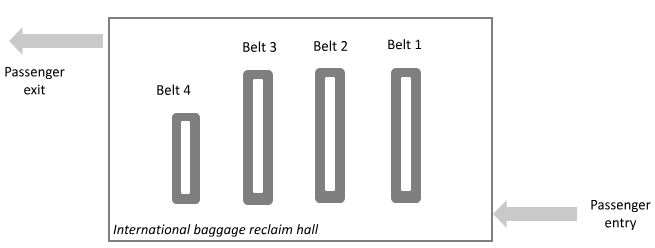

## Additional info

IATA standard for acceptable wait times is < 15 minutes for baggage reclaim.

The maximum capacity for each belt is listed below: \
Belt 1: 160 bags \
Belt 2: 160 bags \
Belt 3: 160 bags \
Belt 4: 100 bags

### Data
The data comes from a simulation of a peak day at the airport and is given in two data sets.
The first, *bags*, contains a unique belt identifier, time, and number of bags on the belt. The second, *passengers*, contains a passenger ID, the time of entry at the reclaim hall, and the time of bag collection.

Passengers who travel without bags are omitted from the two data sets.



Firstly, I import the necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

I load the data from a publicly available link and have a first look at the data frames.

In [2]:
# Load files using public link
file_id_passengers = '1SJE2iPbW5aw4fgOx6h4wdYQmKyuWSC0y'
file_id_bags = '1i095mLZdpX635D0Lu9snJ5r-0PpNb5Cg'

url1 = f"https://drive.google.com/uc?id={file_id_bags}"
df_bags = pd.read_csv(url1)

url2 = f"https://drive.google.com/uc?id={file_id_passengers}"
df_pass = pd.read_csv(url2)

# First look at data
print(df_bags.head(10))
print(df_bags.tail())

print(df_pass.head())
print(df_pass.tail())

  Processor         Time  Bags
0    BELT 1  12:00:00 AM    37
1    BELT 2  12:00:00 AM    48
2    BELT 4  12:00:00 AM     0
3    BELT 3  12:00:00 AM    68
4    BELT 1  12:01:00 AM    33
5    BELT 2  12:01:00 AM    48
6    BELT 4  12:01:00 AM     0
7    BELT 3  12:01:00 AM    61
8    BELT 1  12:02:00 AM    27
9    BELT 2  12:02:00 AM    48
     Processor  Time  Bags
5759    BELT 3  1.00     0
5760    BELT 1  1.00    31
5761    BELT 2  1.00     2
5762    BELT 4  1.00     0
5763    BELT 3  1.00     0
   Passenger # Start Time End Time
0        13383    0:00:00  0:00:17
1        13365    0:01:17  0:01:32
2        13360    0:00:24  0:00:27
3        13350    0:00:26  0:01:38
4        13402    0:02:16  0:03:20
       Passenger # Start Time  End Time
21356        85917   24:00:04  24:15:11
21357        86105   24:00:34  24:13:21
21358        85949   24:00:29  24:14:58
21359        85937   23:59:27  24:14:34
21360        99999    0:00:00  99:59:59


We can see that some of the data is faulty, so the next step is to clean the data.

# Data cleaning
There are some issues in the time stamps in both data files.

In the *passengers* dataset, I will assume that any timestamp starting with *25*:XX:XX is after midnight, i.e. the next day. Any timestamp starting with 99 is assumed to be an error and will be removed before further analysis.

In the *bags* data set, I will assume that the time stamps are consistent throughout the dataset, i.e. one minute intervals throughout the day.



In [3]:
# Fix time in passenger dataset and remove invalid data

# Define function to clean timestamps
def fix_time_24(time_stamp):

  # Set arbitrary date for datetime format
  base_date = datetime.datetime(2000,1,1)

  # Split time into hours, minutes, seconds
  h, m, s = map(int, time_stamp.split(':'))

  if h == 99: # Here I'm removing all timestamps starting with 99
    return None
  elif h >= 24: # All remaining timestamps larger than 24 are carried over to the next day.
    return base_date + datetime.timedelta(days=1, hours=0, minutes=m, seconds=s)
  else : # The remaining timestamps are kept as-is
    return base_date + datetime.timedelta(hours=h, minutes=m, seconds=s)

# Clean start times
df_pass["Clean_start_time"] = df_pass["Start Time"].apply(fix_time_24)
# Clean end times
df_pass["Clean_end_time"] = df_pass["End Time"].apply(fix_time_24)
# Remove invalid rows
df_pass = df_pass.dropna()


# Clean time in the bags data, assuming constant time spacing throughout the day
df_bags["Clean_time"] = [item for item in pd.date_range("2000-01-01", periods=df_bags.Processor.value_counts()["BELT 1"], freq="min") for i in range(4)]

# Analysis of Belt Capacity


In [4]:
# Define max capacity of each belt
belt_lengths = {
  'BELT 1': 160,
  'BELT 2': 160,
  'BELT 3': 160,
  'BELT 4': 100
}

# Check if capacity is exceeded
df_bags["Capacity"] = df_bags["Processor"].map(belt_lengths)
df_bags["At_max_capacity"] = df_bags["Bags"] == df_bags["Capacity"]

# How big of a fraction of the day is each belt at maximum capacity?
print("Percentage of time that each belt is at maximum capacity:")
print(df_bags.groupby("Processor")["At_max_capacity"].value_counts(normalize=True)*100)

Percentage of time that each belt is at maximum capacity:
Processor  At_max_capacity
BELT 1     False               91.325468
           True                 8.674532
BELT 2     False              100.000000
BELT 3     False               99.791811
           True                 0.208189
BELT 4     False               99.722415
           True                 0.277585
Name: proportion, dtype: float64


Only Belt 1 is seen to be at maximum capacity at a significant amount of time.

Let's look at capacity over time for each belt, to see when max capacity is reached.

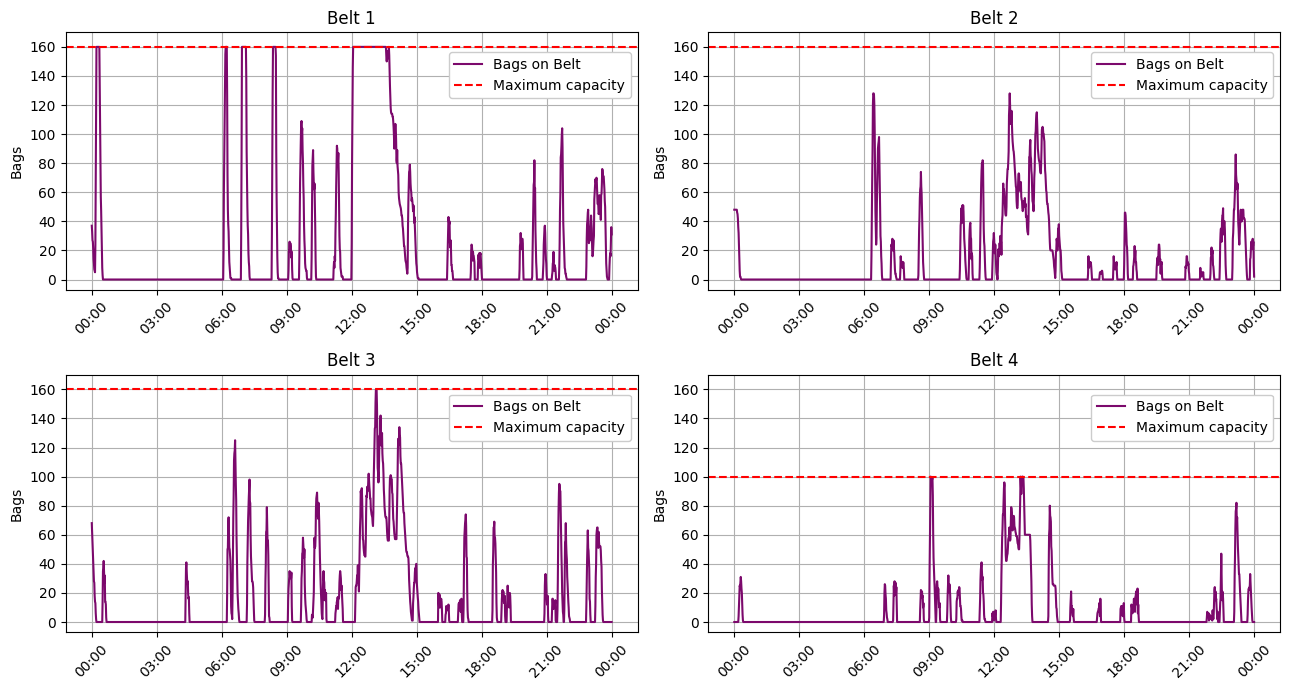

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(13, 7), sharex=False, sharey = False)
axes = axes.flatten()

belts = sorted(df_bags["Processor"].unique())  # Sort so belts are in order
for i, belt in enumerate(belts):
  ax = axes[i]
  belt_data = df_bags[df_bags["Processor"] == belt]

  # Plot bag counts
  ax.plot(
    belt_data["Clean_time"],
    belt_data["Bags"],
    color = '#7C096C',
    label='Bags on Belt'
  )

  # Plot max capacity line
  ax.axhline(
    y=belt_lengths[belt],
    color='red',
    linestyle='--',
    label='Maximum capacity'
  )

  # Format time axis to only show HH:MM
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

  ax.set_title(f"{belt.title()}")
  ax.set_ylabel("Bags")
  ax.tick_params(axis='x', rotation=45)
  ax.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.95))

  # Set grid lines
  ax.grid()

  # Set axis constraints
  ax.set_ylim([-7, 170])

# Adjust layout
plt.tight_layout()
plt.show()

The majority of the wait time at Belt 1 is seen to be after midday.

# Analysis of Passenger Wait Times
Next, let's have a look at how long passengers are waiting for. \
IATA standard for acceptable wait times is < 15 minutes for baggage claim.

In [6]:
# Calculate wait times
df_pass["Wait_time"] = df_pass["Clean_end_time"] - df_pass["Clean_start_time"]
df_pass["Wait_time_mins"] = df_pass['Wait_time'].dt.total_seconds() / 60

# Summary of wait times
print("Mean wait time is:", df_pass["Wait_time"].mean())
print("Median wait time is:", df_pass["Wait_time"].median())
print("Maximum wait time is:", df_pass["Wait_time"].max())
print("The 25th quantiles is:", df_pass["Wait_time"].quantile(0.25))
print("The 75th quantiles is:", df_pass["Wait_time"].quantile(0.75))

Mean wait time is: 0 days 00:05:26.274263776
Median wait time is: 0 days 00:04:43
Maximum wait time is: 0 days 00:21:26
The 25th quantiles is: 0 days 00:01:06
The 75th quantiles is: 0 days 00:08:42


In [7]:
# Calculate number of passengers waiting more than 15 mins
acceptable_wait_time = datetime.timedelta(minutes=15)
unacceptable_waits = len(df_pass.loc[df_pass["Wait_time"]>=acceptable_wait_time])
print(f"Out of {len(df_pass)} passengers, {unacceptable_waits} waited 15 minutes or more. That's {round(100*unacceptable_waits / len(df_pass),2)}%.")


very_unacceptable_waits = len(df_pass.loc[df_pass["Wait_time"]>=datetime.timedelta(minutes=20)])
print(f"Out of {len(df_pass)} passengers, {very_unacceptable_waits} waited 20 minutes or more. That's {round(100*very_unacceptable_waits / len(df_pass),2)}%.")

Out of 21359 passengers, 616 waited 15 minutes or more. That's 2.88%.
Out of 21359 passengers, 18 waited 20 minutes or more. That's 0.08%.


Let's have a look at what that looks like as a histogram

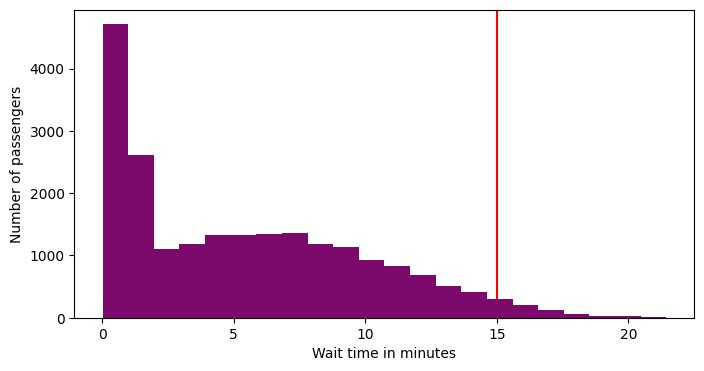

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.axvline(x=datetime.timedelta(minutes=15).total_seconds()/60,c='r',zorder=0)
ax.hist(df_pass["Wait_time_mins"],color='#7C096C',bins = len(pd.unique(round(df_pass['Wait_time_mins']))))
plt.xlabel('Wait time in minutes')
plt.ylabel('Number of passengers')
plt.show()

We can see that the most frequently occuring wait times are 1-2 minutes.

# Analysis of Occupancy
As the final part of the analysis, lets have a look at the occupancy of the reclaim hall.

In [9]:
# Create events list to count waiting passengers
events = []
for arr in df_pass["Clean_start_time"]:
  events.append((arr, 1))
for dep in df_pass["Clean_end_time"]:
  events.append((dep, -1))

# Sort events (arrivals before departures if same time)
events.sort(key=lambda x: (x[0], -x[1]))

# Sweep through to build time vs count lists
times = []
counts = []
current_count = 0
for time, change in events:

  # Record previous state before the change for step plotting
  if times:
    times.append(time)
    counts.append(current_count)

  # Apply change
  current_count += change

  # Record new state after change
  times.append(time)
  counts.append(current_count)

Now let's plot the results of that

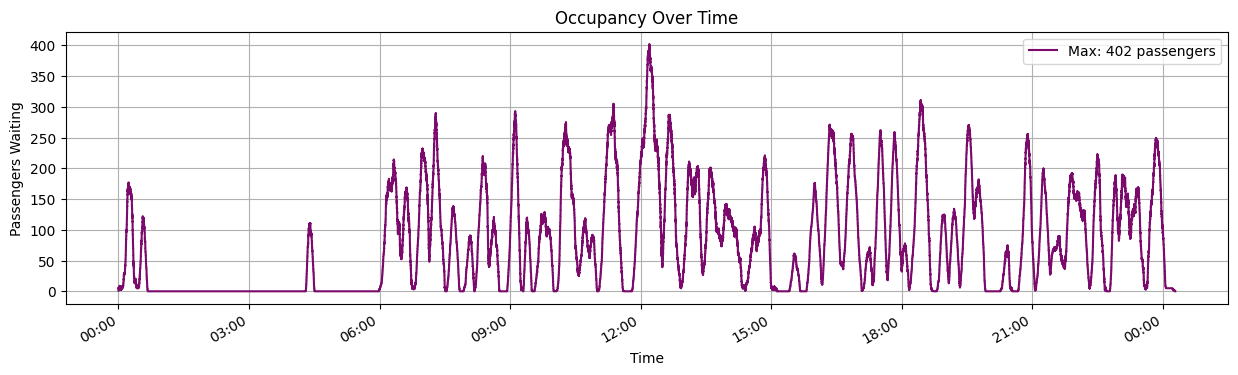

In [10]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.step(times, counts, where='post', color = '#7C096C', label=f"Max: {max(counts)} passengers")

ax.set_xlabel("Time")
ax.set_ylabel("Passengers Waiting")
ax.set_title("Occupancy Over Time")
ax.grid(True)

# Format X-axis as HH:MM
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()

ax.legend()
plt.show()

The maximum number of waiting passengers occurs just after midday with 402 passengers waiting at the same time. This co-incides with Belt 1 being at maximum capacity for an extended amount of time.

# Conclusion

I set out to answer three questions in this analysis:
1. Do the belts have suffucient capacity?
2. Are wait times acceptable?
3. What is the maximum number of passengers waiting simultaniously in the baggage reclaim hall?

Bear in mind, that the data is from a simulation of a peak day. Therefore most days at the airport will see less trafic than what is analysed here.
Answers:
1. Belts 2-4 have sufficient capacity, while Belt 1 was at maximum capacity 9% of the time.
2. Wait times are acceptable, as less than 3% of passengers waited more than 15 mins.
3. The maximum occupancy of the reclaim hall is 402 passengers.


# Recommendations for further analysis
*   Add flight ID from the simulation to the passengers data set. This will allow for an analysis of whether the bags can be distributed differently across the belts. Remember that all bags from the same flight are brought to the same belt.
*   Use the 3D simulation to simulate wait times with other belt layouts to compare multiple design options for the baggage reclaim hall.
*   Review layout options, to avoid congestion at passenger entry point.

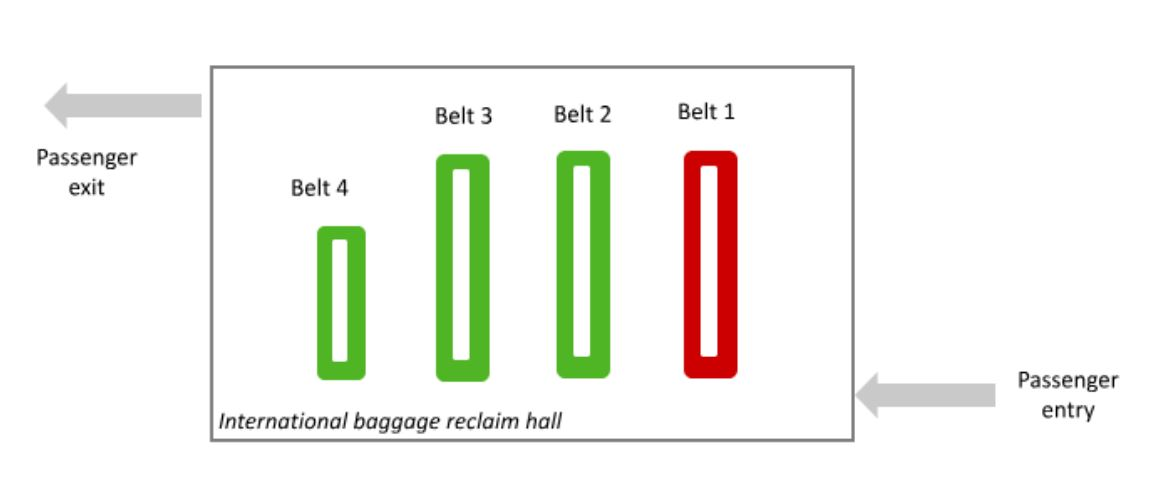